# AB testing: Bayesian thinking

Years ago, I was assigned to explore the Bayesian AB testing for the AB testing system of the company. There are many good things about Bayesian approach that make it very charming to business: (1) Intuitive; (2) No worries about sample size; etc.

I had a look, but it is too complicated to understand. I kept myself away from Bayesian (and sometimes excuse myself that we are good enough with Frequentist). After few years, I browsed the Internet, and realize that the writings about Bayesian are EITHER academically/mathematically complciated OR marketing-oriented with all dazzling words without explaing the core nature of this approach.

> **Motivation**: It's why I create this hands-on notebooks, trying to explain the concept with very simple maths, utilizing visualization. But the most important thing, give you the sense of Bayesian thinking and connect it a very practical exercise we do from time to time: AB testing, not only from technical perspective (accuracy), but business perspective (cost, impact)


**What makes this notebook interesting**
- There are Bayes, Probability, P-value, but as little maths as possible.
- Prioritize the ease-to-understand. As the trade-off, some details could be over-simplified, but I hope you agree that it worths to do so
- Pratically speaking, finally we want to link back to AB testing with the considerations about business impacts

As the notebooks is more about introducing the Bayesian way of thinking, I recommend to read on other sources that deep-dive into the concepts.

**Reference**
[Think Bayes 2, by Allen B. Downey](https://allendowney.github.io/ThinkBayes2/)




-------------- BEGINNING OF NOTEBOOK --------------

In [ ]:
# Install empiricaldist
!pip install empiricaldist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12122 sha256=d88a289a5a53b2191231a09f4d91615008918515b622d90d5eb5916fae596958
  Stored in directory: /root/.cache/pip/wheels/c2/2f/73/700abc644ee5aba92a8b40552794103c445cd47fcdfe7828f7
Successfully built empiricaldist


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom, norm
from empiricaldist import Pmf
import seaborn as sns

# Bayes's theorem: terminologies

The purpose of this part is only to set the ground, by:

*   (1) Re-warm your basic knowledge on Bayes's theorem, and
*   (2) Introduce the terminologies of `prior`, `likelihood`, `posterior`



This is the formula of Bayes's theorem
```
P(A|B) = P(A)P(B|A) / P(B)
```
In which:
- `P(B)`, `P(A)`: Probability of event A and B, respectively
- `P(A|B)`: Probability of event A, knowing that B already happens

**🍪🍪🍪 Cookie Problem 🍪🍪🍪**

Now, we have 2 bowls contain vanilla and chocolate cookies. You know that:

- Bowl 1 = [🍪🍪🍪🍫] => have 3/4 vanilla cookies
- Bowl 2 = [🍪🍪🍫🍫] => have 1/2 vanilla cookies

We randomly pick one out of 2 bowls, and then pick a cookie.
It is vanilla 🍪?

> Which one is more likely the bowl that we picked?


In [ ]:
b1 = ['vanilla'] * 30 + ['chocolate'] * 10
b2 = ['vanilla'] * 20 + ['chocolate'] * 20
p_b1 = 1/2
N = len(b1) + len(b2)
p_vanilla = (b1.count('vanilla') + b2.count('vanilla')) / N
p_chocolate = 1 - p_vanilla
p_vanilla_b1 = b1.count('vanilla') / len(b1)
p_vanilla_b2 = b2.count('vanilla') / len(b2)
p_b1_vanilla = p_vanilla_b1 * p_b1 / p_vanilla
p_b1_vanilla

0.6

In [ ]:
# TODO_1:
# Let's stop here and think. No code is required. You can take a paper and pencil
# Hints: Using the Bayes' theorem

And, here is another way to think about Bayes's theorem:

- We put H (Hypothesis) is which bowl that we pick => 2 cases: `bowl_1` and `bowl_2`
- D (data) is our observations that we picked 1 Vanilla 🍪

```
P(H|D) = P(H)P(D|H) / P(D)
```

- `P(H)` is the probability of Hypothesis before we see the data => **Prior**
  - `P(bowl_1) = 1/2`
  - `P(bowl_2) = 1/2`
- `P(D|H)` is the prob. to pick 1 Vanilla under `bowl_1` => **Likelihood**:
  - Observed Vanilla rate on sample: `0.75` on `bowl_1`
  - Observed Vanilla rate on sample: `0.475` on `bowl_2`
- `P(D)`: Total probability for pick 1 Vanilla under any hypothesis: `0.75` + `0.475` => `Normalizer`: It is to normalize `P(H)P(D|H)` to 1
- Finally, `P(H|D)` would be the one we care the most ==> **Posterior**: probability of each hypothesis (`bowl_1` or `bowl_2` under the obsevation that we picked out 1 Vanilla 🍪)

_Don't be panic! We will jump to the code now!_

In [ ]:
# Generate 2 bowls contains different proportions of vanilla/chocolate
bowl_1 = ['vanilla'] * 300 + ['chocolate'] * 100
bowl_2 = ['vanilla'] * 200 + ['chocolate'] * 200

In [ ]:
# Not Pythonic code
# This is the likelihood to pick 1 Vanilla under bowl_1 and bowl_2
p_vanilla_b1 = bowl_1.count('vanilla') / len(bowl_1)
p_vanilla_b2 = bowl_2.count('vanilla') / len(bowl_2)
print(f'P(vanialla|bowl_1): {p_vanilla_b1}')
print(f'P(vanialla|bowl_2): {p_vanilla_b2}')

P(vanialla|bowl_1): 0.75
P(vanialla|bowl_2): 0.5


In [ ]:
# TODO_2:
# The code above is not Pythonic
# Create the function calc_p_vanilla(bowl) to calculate the p_vanialla in each bowl

# def calc_p_vanilla(bowl):
#   'YOUR CODE'

In [ ]:
# TEST
assert calc_p_vanilla(bowl_1) == 0.75
assert calc_p_vanilla(bowl_2) == 0.5
print('TEST: calc_p_vanilla ===> PASS!!!')

TEST: calc_p_vanilla ===> PASS!!!


In [ ]:
# Hypothesis: We have 2 - Bowl 1 or Bowl 2
table = pd.DataFrame(index=['Bowl 1', 'Bowl 2'])

# Prior:
# Even before picking the Vanilla,
# we know each bowl have 50:50 to be picked
table['prior'] = 1/2, 1/2

# Likelihood:
# Of the fact that we pick Vanilla,
table['likelihood'] = p_vanilla_b1, p_vanilla_b2
table['unnorm'] = table.prior * table.likelihood

# Posterior:
# Force the p_posterior to add up to 1
table['posterior'] = table.unnorm / table.unnorm.sum()
table

,prior,likelihood,unnorm,posterior
Bowl 1,0.5,0.75,0.375,0.6
Bowl 2,0.5,0.50,0.250,0.4


Now, for convenience, we use `empiricaldist` to help us doing the above steps, with fewer lines of code.

- Our "belief": represented by `Pmf` object, _"probability mass functions"_, Dataframe that represent the distribution of our interested value
- The belief is update with data (`likelihood`)
- After normalize, we have new "belief" (**posterior**)

In [ ]:
# Probability mass function: discrete
prior = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


In [ ]:
likelihood_vanilla = p_vanilla_b1, p_vanilla_b2
likelihood_chocolate = 1 - p_vanilla_b1, 1 - p_vanilla_b2
posterior = prior * likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


In [ ]:
likelihood_vanilla

(0.75, 0.5)

This is only to get you familar with the terminologies and code.
Magic is coming next!

# Bayes updates: from pior to posterior

🍪🍪🍪 Now, we not only have 2, but we haev 101 bowls:

- Bowl 0 contains 0% vanilla cookies,
- Bowl 1 contains 1% vanilla cookies,
- Bowl 2 contains 2% vanilla cookies,
- ...
- Bowl 100 contains 100% vanilla coolies,

We also pick 1 bowl, then 1 cookie, it is Vanilla.
> **What is the probability that the cookies came from Bowl x, with x from 0 to 100?**

In [ ]:
# Space of hypothesis (101 bowls)
hypos = np.arange(101)
hypos

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [ ]:
# THIS IS HIDDEN TILL LATER
# We randomly choose 1 bowl (hypos)
# Then, we generate the data corresponding to that hypos
np.random.seed(1234)
# Select the bowl
selected_hypo = 90 #np.random.choice(hypos, 1)[0]
# Contents in the selected bowl
selected_hypo_bowl = ['vanilla'] * selected_hypo + ['chocolate'] * (100 - selected_hypo)

We cannot pour out the whole whole and count, but we are allowed to pick multiple times (up to 50 times out of 100 cookies in the bowl).
How we adjust our belief:
- If we pick out 1 "Vanilla", which hypothesis we should kill?
- If we continuously pick "Vanilla" out of the bowl, which hypothesis we should favour?
- Vice versa?

In [ ]:
# TODO_3: Answer the question above

We cannot pour out the whole whole and count, but we are allowed to pick multiple times (up to 50 times out of 100 cookies in the bowl).
How we adjust our belief:
- If we pick out 1 "Vanilla", which hypothesis we should kill?
- If we continuously pick "Vanilla" out of the bowl, which hypothesis we should favour?
- Vice versa?

In [ ]:
# TODO_4:
# From the code in prev session
# Write update_data func, to update the posterior,
# with new obs: vanilla or chocolate
# likelihood: define as above
def update_data(posterior, new_obs, likelihoods):
    posterior = posterior * likelihoods[new_obs]
    posterior.normalize()
    return posterior

In [ ]:
# TEST
test_prior = Pmf(1, ['bowl_1', 'bowl_2'])
test_prior.normalize()

test_likelihood = {
    'vanilla': likelihood_vanilla,
    'chocolate': likelihood_chocolate,
}

update_data(test_prior, 'vanilla', test_likelihood)

,probs
bowl_1,0.6
bowl_2,0.4


Max_prob predicted hypo: 100
Max_prob predicted hypo: 95
Max_prob predicted hypo: 97
Max_prob predicted hypo: 98


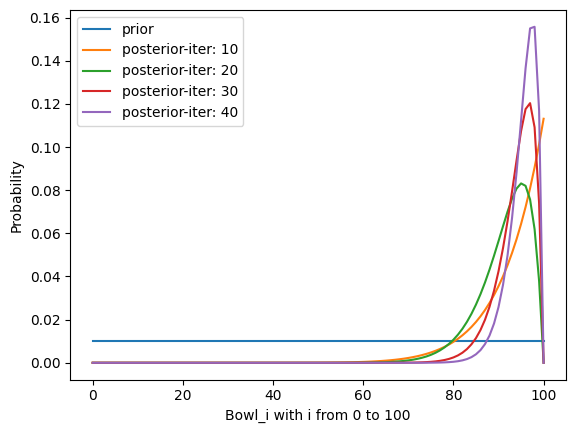

In [ ]:
# What we actually observed, subset of outcomes
# Data
observed_picks = np.random.choice(selected_hypo_bowl, size=50)

# Likelihood of Vanilla/Chocolate under each hypos
likelihood_vanilla = hypos / 100
likelihood_chocolate = 1 - likelihood_vanilla
likelihoods = {
    'vanilla': likelihood_vanilla,
    'chocolate': likelihood_chocolate
}

# Create PRIOR
prior = Pmf(1, hypos)
prior.normalize()

# BAYES UPDATE
# (1) Pick up 1 cookies from the selected bowl (and return)
# (2) Update the previous belief on the observed outcome (Vanilla/chocolate)
# (3) Pick another cookie, repeat

iter = []
observations = []
updated_posterior = [prior]

for i, observed_pick in enumerate(observed_picks):
  if i == 0:
    plt.plot(prior, label=f'prior')
    posterior = update_data(prior, observed_pick, likelihoods)
  else:
    posterior = update_data(posterior, observed_pick, likelihoods)
    if i % 10 == 0:
      plt.plot(posterior, label=f'posterior-iter: {i}')
      plt.legend()
      print(f'Max_prob predicted hypo: {posterior.max_prob()}')

  iter.append(i)
  observations.append(observed_pick)
  updated_posterior.append(posterior)

plt.xlabel('Bowl_i with i from 0 to 100')
plt.ylabel('Probability');

**Implications**
1. We start with flat **Prior**, every bowl have the equal chance to be picked
2. After 10 picks of cookies, we lean toward Bowl 60+ ==> Because we observe a lot "vanilla" there, check: `observations[:10]`
3. With more and more picks, the posterior distribution starts to move to the "supposed" to be the right "guess" (WE WILL CHECK LATER)

> **Takeway:** Bayes' update = update belief with data coming.

In [ ]:
# TODO_5
# Compare the max_pob of final posterior (after 50 updates)
# With the selected_hypo (hidden)
print(selected_hypo)

90


In [ ]:
updated_posterior[-1].max_prob()

94

The **101 cookies bowl** 🍪🍪🍪 is actually the **Proportion estimation**:

- In 101 bowls, we predict bowl X, with `X%` of Vanilla. It appears to be predict the `X%`, the proportion of Vanilla in the bowl
- This is what we would do next in estimating the proportion

# Estimate proportion

Why we ever need the estimation?
Because we never have the population data, we only have a sample.

For example, we have all people in Vietnames (**population**), if we can measure the height of everyone, we will have the **average of the population**. But, we are only able to interview 1,000 people (**sample** = subset of the whole possible data), we can calculate the **average** on this sample.

> But, this is NOT the "truth" (the "actual") value of population average, we use the measure on sample as the estimate for the population.

As it is just an estimate, we present it with the **confident interval**

## Bayes way

> We have a coin. We not sure if it is "fair" or "biased". If it's "fair", the `P(Head) = P(Tail) = 0.5`
After a X times of flipping the coin, we want to estimate the `P(Head)`

What we will do:

- Randomly select a `p_H_actual` (hidden truth)
- Generate the data from the hidden truth, our data is limited by size `N_data` (actually it is the sample of many possibilities that we can collect)
- Use Bayesian approach, try to estimate the `p_H`

We picked the `p_H_actual` from the triangular, motivated by the intuition that the rate of head should be peak around 0.5, and declined over more extreme values.

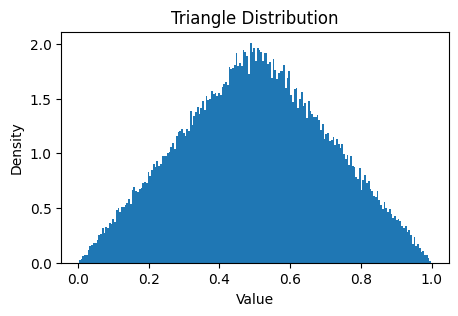

In [ ]:
#@title
mode_val = 0.5

plt.figure(figsize=(5, 3))
plt.hist(np.random.triangular(0, mode_val, 1, 100000), bins=200, density=True)
plt.title('Triangle Distribution')
plt.xlabel('Value')
plt.ylabel('Density');

In [ ]:
# THIS IS HIDDEN TILL LATER
p_H_actual = np.random.triangular(0, 0.5, 1)

In [ ]:
# We write the function to update the distribution
# with all obs at-once rather than one by one update
def update_dataset(prior, data, likelihoods):
  posterior = prior.copy()
  for obs in data:
    posterior *= likelihoods[obs]
  posterior.normalize()
  return posterior

N = 5 - Pred: 0.80
N = 50 - Pred: 0.62
N = 200 - Pred: 0.71
N = 500 - Pred: 0.58
Actual P(H): 0.61
Estimated p(H): 0.58


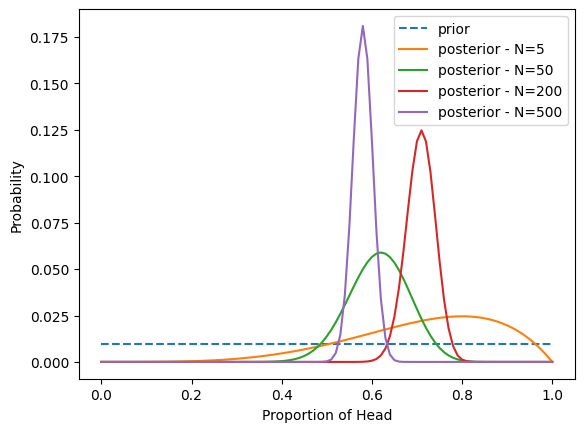

In [ ]:
# Assume that all it will take any values from 0 to 1
hypos = np.linspace(0, 1, 101)

# Define prior
prior = Pmf(1, hypos)
prior.normalize()

# Define likelihoods of obs at each hypos
# TODO_6: Create the likelihood
likelihoods = {
    'H': #YOUR-CODE,
    'T': #YOUR-CODE
}
plt.plot(prior, label='prior', linestyle='--')

for N_data in [5, 50, 200, 500]:
  # TODO_7: For different sample size, randomly return the output of H or T
  data = list(np.random.choice('YOUR-CODE'))
  # TODO_8: Update the prior with the data, using update_data
  posterior = update_dataset('YOUR-CODE')

  # Plot
  plt.plot(posterior, label=f'posterior - N={N_data}')
  plt.legend()
  plt.xlabel('Proportion of Head')
  plt.ylabel('Probability')
  obs_pct = data.count('H') / len(data)
  print(f'N = {N_data} - Pred: {posterior.max_prob():.2f}')

print('=' * 20)
print(f'Actual P(H): {p_H_actual:.2f}')
print(f'Estimated p(H): {posterior.max_prob():.2f}')

# Save this posterior under prio uniform
posterior_uniform = posterior

From the uniform prior, after more flips of coin, we come closer to the actual proportion. This is quite similar to "Frequentist" - classicial approach, with more data, your estimation becomes better.

## Different priors

> One of the most common challenge around Bayes is: The subjectivity on the prior.

We will try to run under another prior assumption. Now, it will not the uniform, but a triangle prior distribution.

N = 5 - Proportion on data: 0.40 (Pred: 0.50)
N = 50 - Proportion on data: 0.62 (Pred: 0.61)
N = 200 - Proportion on data: 0.59 (Pred: 0.59)
N = 500 - Proportion on data: 0.60 (Pred: 0.60)
Actual P(H): 0.61
Estimated p(H): 0.60


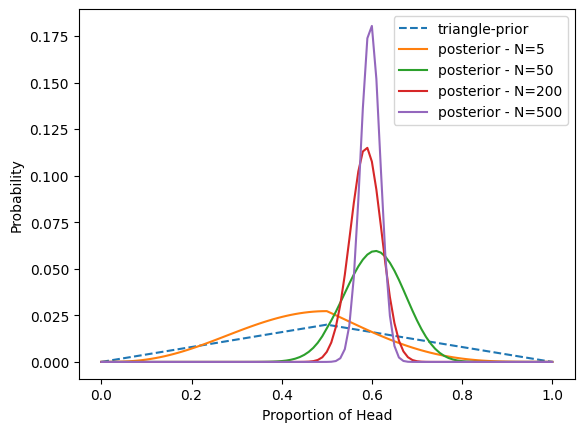

In [ ]:
#@title
# Assume that all it will take any values from 0 to 1
hypos = np.linspace(0, 1, 101)

# Define prior
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle_prior = Pmf(a, hypos, name='triangle_prior')
triangle_prior.normalize()

# Define likelihoods of obs at each hypos
likelihoods = {
    'H': hypos,
    'T': 1 - hypos
}
plt.plot(triangle_prior, label='triangle-prior', linestyle='--')

for N_data in [5, 50, 200, 500]:
  data = list(np.random.choice(['H', 'T'], size=N_data, p=[p_H_actual, 1 - p_H_actual]))
  posterior = update_dataset(triangle_prior, data, likelihoods)
  plt.plot(posterior, label=f'posterior - N={N_data}')
  plt.legend()
  plt.xlabel('Proportion of Head')
  plt.ylabel('Probability')
  obs_pct = data.count('H') / len(data)
  print(f'N = {N_data} - Proportion on data: {obs_pct:.2f} (Pred: {posterior.max_prob():.2f})')

print('=' * 20)
print(f'Actual P(H): {p_H_actual:.2f}')
print(f'Estimated p(H): {posterior.max_prob():.2f}')
posterior_triangle = posterior

We can see that the choice of prior leads to different posterior, but only for the small `N`, once the data size increase, the posteriors become more similar.

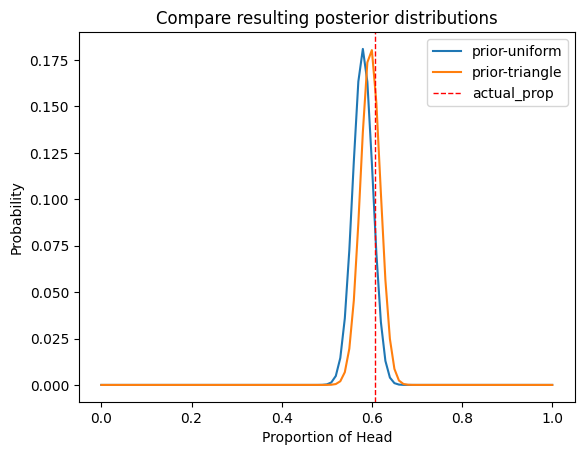

In [ ]:
#@title
# Compare 2 different prior
plt.plot(posterior_uniform, label='prior-uniform')
plt.plot(posterior_triangle, label='prior-triangle')
plt.axvline(x=p_H_actual, color='red', linestyle='--', linewidth=1, label='actual_prop')
plt.legend()
plt.title('Compare resulting posterior distributions')
plt.xlabel('Proportion of Head')
plt.ylabel('Probability');

## Confidence interval

In [ ]:
# TODO_9: With the posterior (output)
# define the confident internval of 0.95
posterior_triangle

,probs
0.00,0.000000e+00
0.01,0.000000e+00
0.02,0.000000e+00
0.03,0.000000e+00
0.04,0.000000e+00
...,...
0.96,1.941105e-142
0.97,2.489282e-166
0.98,0.000000e+00
0.99,0.000000e+00


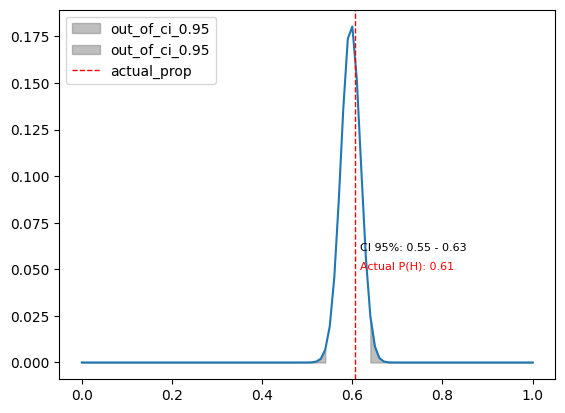

In [ ]:
#@title Solution: plot_ci_area
def plot_ci_area(pmf_k, ci_level=0.95):
  cumsum_pct = pmf_k.cumsum()
  ci = (1 - ci_level) / 2
  ci = cumsum_pct[(cumsum_pct >= ci) & (cumsum_pct <= 1 - ci)]
  ci = (ci.index[0], ci.index[-1])
  ci_idx = pmf_k.index[pd.Series(pmf_k.index).between(*ci)]
  ci_lower_idx = pmf_k.index < ci[0]
  ci_upper_idx = pmf_k.index > ci[1]
  label = f'out_of_ci_{ci_level}'
  plt.fill_between(pmf_k[ci_lower_idx].index, pmf_k[ci_lower_idx], alpha=0.5, color='gray', label=label)
  plt.fill_between(pmf_k[ci_upper_idx].index, pmf_k[ci_upper_idx], alpha=0.5, color='gray', label=label)
  return ci

# Plot
posterior = posterior_triangle

plt.plot(posterior)
ci = plot_ci_area(posterior, ci_level=0.95)
plt.axvline(x=p_H_actual, color='red', linestyle='--', linewidth=1, label='actual_prop')
plt.text(p_H_actual + 0.01, 0.06, f'CI 95%: {ci[0]:.2f} - {ci[1]:.2f}', fontsize=8)
plt.text(p_H_actual + 0.01, 0.05, f'Actual P(H): {p_H_actual:.2f}', fontsize=8, color='red')
plt.legend(loc='upper left');

We construct the 95% confident inverval, and the actual value is within the range by Bayesian approach.

## Frequentist way

A refresher for the approach in Frequentist:

1. We take the observed `p_obs` from the data, as the **estimate of the actual values (from population)**
2. We have a fixed assumption about the distribution. In this case, the Binomial distribution (observed K out of N data point for a binary outcome, with p)
2. The `p_actual` could be any value under the distribution, around the estimate (`p_obs`)
3. By the assumed distribution, we can build the confident interval around the estimate

In [ ]:
def gen_binomial_dist(n_data, p_h0):
  # For the data of N, we could observe 1 to n of H
  k_values = np.arange(n_data+1)
  p_k = binom.pmf(k_values, n_data, p_h0) # Prob to observe each cases, under null hypo
  pmf = Pmf(p_k, k_values)
  return pmf

In [ ]:
# Frequentist
# Estimate by the observed value on sample
n_data = len(data)
p_obs = data.count('H') / n_data
print(f'N of data: {n_data}')
print(f'Observed prob(H) on data: {p_obs}')

N of data: 500
Observed prob(H) on data: 0.598


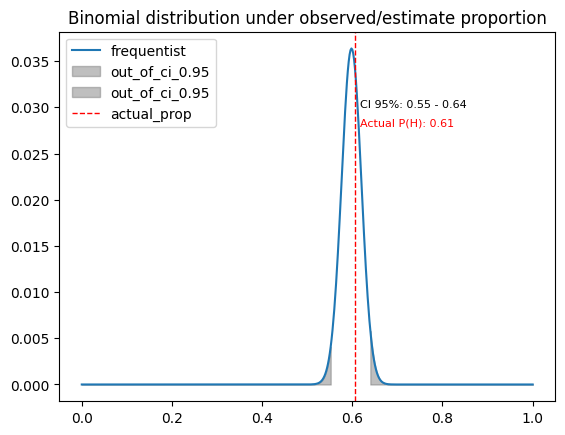

In [ ]:
#@title
# Distribution: Binomial
pmf_k = gen_binomial_dist(n_data, p_obs)
pmf_k.index = (pmf_k.index / 500)

plt.plot(pmf_k, label='frequentist')
ci = plot_ci_area(pmf_k, ci_level=0.95)
plt.axvline(x=p_H_actual, color='red', linestyle='--', linewidth=1, label='actual_prop')
plt.text(p_H_actual + 0.01, 0.03, f'CI 95%: {ci[0]:.2f} - {ci[1]:.2f}', fontsize=8)
plt.text(p_H_actual + 0.01, 0.028, f'Actual P(H): {p_H_actual:.2f}', fontsize=8, color='red')
plt.title('Binomial distribution under observed/estimate proportion')
plt.legend(loc='upper left');

In [ ]:
# By existing python package
from statsmodels.stats.proportion import proportion_confint
ci_freq_binom = proportion_confint(count=data.count('H'), nobs=len(data))
ci_freq_binom

(0.5550239291079423, 0.6409760708920577)

In [ ]:
# From the empirical distribution curve
# TODO_10: Get the 95% interval
# YOUR-CODE

(0.552, 0.64)

In [ ]:
# By mathematical formula
# TODO_11: By the formula on this link
# https://sigmazone.com/binomial-confidence-intervals/
# Calculate the 95% interval of the estimate
z_scores = norm.ppf(0.025), norm.ppf(.975)
# YOUR_CODE

(0.5723003096065494, 0.6236996903934505)